# Conditional with MNIST (or Fashion MNIST)

* `Conditional Generative Adversarial Nets`[arXiv:1411.1784](https://arxiv.org/abs/1411.1784)
  * Mehdi Mirza and Simon Osindero
  
* This code is available to tensorflow version 2.0
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) [`tf.losses`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses)
* Use `transposed_conv2d` and `conv2d` for Generator and Discriminator, respectively.
  * I do not use `dense` layer for model architecture consistency. (So my architecture is different from original dcgan structure)
* based on DCGAN model

## 1. Import modules

In [1]:
import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 2. Setting hyperparameters

In [3]:
# Training Flags (hyperparameter configuration)
model_name = 'cgan'
train_dir = os.path.join('train', model_name, 'exp1')
dataset_name = 'mnist'
assert dataset_name in ['mnist', 'fashion_mnist']

max_epochs = 50
save_model_epochs = 10
print_steps = 100
save_images_epochs = 1
batch_size = 256
learning_rate_D = 1e-4
learning_rate_G = 1e-3
k = 1 # the number of step of learning D before learning G (Not used in this code)
num_classes = 10 # number of classes for MNIST
num_examples_to_generate = num_classes
noise_dim = 100
MNIST_SIZE = 28

## 3. Load the MNIST dataset

In [4]:
# Load training and eval data from tf.keras
if dataset_name == 'mnist':
  (train_images, train_labels), _ = \
      tf.keras.datasets.mnist.load_data()
else:
  (train_images, train_labels), _ = \
      tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(-1, MNIST_SIZE, MNIST_SIZE, 1).astype('float32')
#train_images = train_images / 255. # Normalize the images to [0, 1]
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

## 4. Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [5]:
def convert_shape_and_type_for_labels(x, y):
  y = tf.one_hot(y, depth=num_classes)
  y = tf.reshape(y, shape=[1, 1, num_classes])
  y = tf.cast(y, dtype = tf.float32)
  return x, y

In [6]:
#tf.random.set_seed(219)
# for train
N = len(train_images)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.map(convert_shape_and_type_for_labels)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
print(train_dataset)

<BatchDataset shapes: ((256, 28, 28, 1), (256, 1, 1, 10)), types: (tf.float32, tf.float32)>


2021-12-23 21:13:55.537720: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-23 21:13:55.969693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22318 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


## 5. Create the generator and discriminator models

In [7]:
class ConvTranspose(tf.keras.Model):
  def __init__(self, filters, kernel_size, padding='same',
               apply_batchnorm=True, activation='relu'):
    super(ConvTranspose, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    assert activation in ['relu', 'sigmoid', 'tanh']
    self.activation = activation
    self.up_conv = layers.Conv2DTranspose(filters=filters,
                                          kernel_size=(kernel_size, kernel_size),
                                          strides=2,
                                          padding=padding,
                                          kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                          use_bias=not self.apply_batchnorm)
    if self.apply_batchnorm:
      self.batchnorm = layers.BatchNormalization()

  def call(self, x, training=True):
    # conv transpose
    x = self.up_conv(x)
    
    # batchnorm
    if self.apply_batchnorm:
      x = self.batchnorm(x, training=training)
      
    # activation
    if self.activation == 'relu':
      x = tf.nn.relu(x)
    elif self.activation == 'sigmoid':
      x = tf.nn.sigmoid(x)
    else:
      x = tf.nn.tanh(x)
    
    return x

In [8]:
class Generator(tf.keras.Model):
  """Build a generator that maps latent space to real space given conditions.
    G(z, c): (z, c) -> x
  """
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = ConvTranspose(256, 3, padding='valid')
    self.conv2 = ConvTranspose(128, 3, padding='valid')
    self.conv3 = ConvTranspose(64, 4)
    self.conv4 = ConvTranspose(1, 4, apply_batchnorm=False, activation='tanh')

  def call(self, noise_inputs, conditions, training=True):
    """Run the model."""
    # noise_inputs: [1, 1, 100]
    # conditions: [1, 1, 10] (for MNIST)
    # inputs = 1 x 1 x (100 + 10) dim
    inputs = tf.concat([noise_inputs, conditions], axis=3)
    conv1 = self.conv1(inputs, training=training)           # conv1: [3, 3, 256]
    conv2 = self.conv2(conv1, training=training)            # conv2: [7, 7, 128]
    conv3 = self.conv3(conv2, training=training)            # conv3: [14, 14, 64]
    generated_images = self.conv4(conv3, training=training) # generated_images: [28, 28, 1]
    
    return generated_images

In [9]:
class Conv(tf.keras.Model):
  def __init__(self, filters, kernel_size, strides, padding='same',
               apply_batchnorm=True, activation='relu'):
    super(Conv, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    assert activation in ['relu', 'leaky_relu', 'none']
    self.activation = activation
        
    self.conv = layers.Conv2D(filters=filters,
                              kernel_size=(kernel_size, kernel_size),
                              strides=strides,
                              padding=padding,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02),
                              use_bias=not self.apply_batchnorm)
    if self.apply_batchnorm:
      self.batchnorm = layers.BatchNormalization()
  
  def call(self, x, training=True):
    # convolution
    x = self.conv(x)
    
    # batchnorm
    if self.apply_batchnorm:
      x = self.batchnorm(x, training=training)
    
    # activation
    if self.activation == 'relu':
      x = tf.nn.relu(x)
    elif self.activation == 'leaky_relu':
      x = tf.nn.leaky_relu(x)
    else:
      pass
    
    return x

In [10]:
class Discriminator(tf.keras.Model):
  """Build a discriminator that discriminate tuple (x, c) whether real or fake.
    D(x, c): (x, c) -> [0, 1]
  """
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = Conv(64, 4, 2, apply_batchnorm=False, activation='leaky_relu')
    self.conv2 = Conv(128, 4, 2, activation='leaky_relu')
    self.conv3 = Conv(256, 3, 2, padding='valid', activation='leaky_relu')
    self.conv4 = Conv(1, 3, 1, padding='valid', apply_batchnorm=False, activation='none')

  def call(self, image_inputs, conditions, training=True):
    """Run the model."""
    # image_inputs: [28, 28, 1]
    # conditions: 10 dim (for MNIST)
    # inputs: [28, 28, (1 + 10)]
    inputs = tf.concat([image_inputs,
                        conditions * tf.ones([image_inputs.shape[0],
                                              MNIST_SIZE, MNIST_SIZE,
                                              num_classes])], axis=3)
    conv1 = self.conv1(inputs)                            # conv1: [14, 14, 64]
    conv2 = self.conv2(conv1)                             # conv2: [7, 7, 128]
    conv3 = self.conv3(conv2)                             # conv3: [3, 3, 256]
    conv4 = self.conv4(conv3)                             # conv4: [1, 1, 1]
    discriminator_logits = tf.squeeze(conv4, axis=[1, 2]) # discriminator_logits: [1,]
    
    return discriminator_logits

In [11]:
generator = Generator()
discriminator = Discriminator()

### Plot generated image via generator network

2021-12-23 21:14:17.331318: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-12-23 21:14:18.037995: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


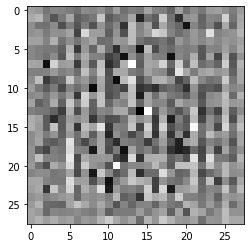

In [12]:
noise = tf.random.normal([1, 1, 1, noise_dim])
condition = tf.one_hot(tf.random.uniform(shape=[], minval=0, maxval=10, dtype=tf.int32), depth=num_classes)
condition = tf.reshape(condition, shape=[1, 1, 1, num_classes])
generated_image = generator(noise, condition, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Test discriminator network

* **CAUTION**: the outputs of discriminator is **logits** (unnormalized probability) NOT probabilites

In [13]:
decision = discriminator(generated_image, condition)
print(decision)

tf.Tensor([[0.13022727]], shape=(1, 1), dtype=float32)


## 6. Define the loss functions and the optimizer

In [14]:
# use logits for consistency with previous code I made
# `tf.losses` and `tf.keras.losses` are the same API (alias)
bce = tf.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def GANLoss(logits, is_real=True):
  """Computes standard GAN loss between `logits` and `labels`.

  Args:
    logits (`2-rank Tensor`): logits.
    is_real (`bool`): True means `1` labeling, False means `0` labeling.

  Returns:
    loss (`0-rank Tensor`): the standard GAN loss value. (binary_cross_entropy)
  """
  if is_real:
    labels = tf.ones_like(logits)
  else:
    labels = tf.zeros_like(logits)

  #return tf.losses.sigmoid_cross_entropy(multi_class_labels=labels, logits=logits)
  return bce(labels, logits)

In [16]:
def discriminator_loss(real_logits, fake_logits):
  # losses of real with label "1"
  real_loss = GANLoss(logits=real_logits, is_real=True)
  # losses of fake with label "0"
  fake_loss = GANLoss(logits=fake_logits, is_real=False)
  
  return real_loss + fake_loss

In [17]:
def generator_loss(fake_logits):
  # losses of Generator with label "1" that used to fool the Discriminator
  return GANLoss(logits=fake_logits, is_real=True)

In [18]:
#discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate_D, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate_D)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate_G, beta_1=0.5)

## Training

In [19]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
# To visualize progress in the animated GIF
const_random_vector_for_saving = tf.random.uniform([num_examples_to_generate, 1, 1, noise_dim],
                                                   minval=-1.0, maxval=1.0)

### Define training one step function

In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, labels):
  # generating noise from a uniform distribution
  noise = tf.random.uniform([batch_size, 1, 1, noise_dim], minval=-1.0, maxval=1.0)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, labels, training=True)

    real_logits = discriminator(images, labels, training=True)
    fake_logits = discriminator(generated_images, labels, training=True)

    gen_loss = generator_loss(fake_logits)
    disc_loss = discriminator_loss(real_logits, fake_logits)
    
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss, disc_loss

### Train full steps

Epochs: 11.53 global_step: 2700 loss_D: 1.32 loss_G: 0.659 (24607.92 examples/sec; 0.010 sec/batch)


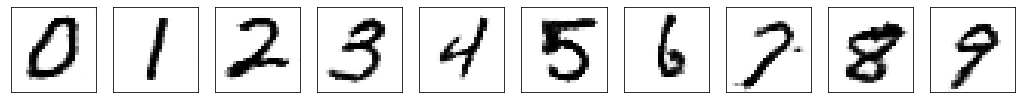

KeyboardInterrupt: 

In [21]:
print('Start Training.')
num_batches_per_epoch = int(N / batch_size)
global_step = tf.Variable(0, trainable=False)

sample_condition = tf.eye(num_classes)
sample_condition = tf.reshape(sample_condition, [-1, 1, 1, num_classes])

for epoch in range(max_epochs):
  
  for step, (images, labels) in enumerate(train_dataset):
    start_time = time.time()

    gen_loss, disc_loss = train_step(images, labels)
    global_step.assign_add(1)

    if global_step.numpy() % print_steps == 0:
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      display.clear_output(wait=True)
      print("Epochs: {:.2f} global_step: {} loss_D: {:.3g} loss_G: {:.3g} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), disc_loss, gen_loss, examples_per_sec, duration))
      noise = tf.random.uniform([num_examples_to_generate, 1, 1, noise_dim], minval=-1.0, maxval=1.0)
      sample_images = generator(noise, sample_condition, training=False)
      plt.figure(figsize=[18, 3])
      for j in range(10):
          plt.subplot(1, 10, j+1)
          plt.imshow(sample_images[j, :, :, 0], cmap='binary')
          plt.xticks([])
          plt.yticks([])
      plt.show()

print('Training Done.')